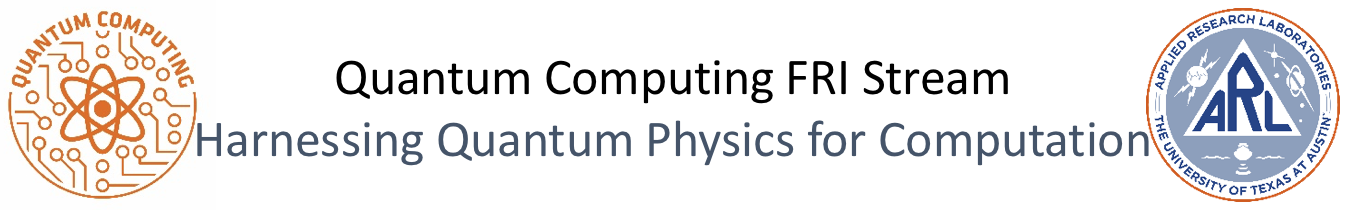

#### Most Recent Lesson: Lesson17 - Perfect Quantum Error Correction

*italicized text*### Installations and Imports

In [1]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
#Let's go ahead and import all this stuff too
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
import numpy as np

In [3]:
def rand(a=0, b=1):
    return a + (b-a)*np.random.random()

# Perfect Quantum Error Correction


Use this notebook to implement a QEC protocol that will do the following:
- Prepare a random single-qubit state.
- Encode the qubit using the 5-qubit perfect code.
- Add a syndrome register (auxiliary qubits) and apply gates to diagnose a syndrome.
- Measure the syndrome and use conditional gates to correct the error.
- Then do it without measuring by using controlled gates (self-correcting code).
- Recall that $\texttt{qc.x(q[0]).c_if(c,2)}$ applies a NOT gate to qubit 0 of the quantum register q if the classical register c is such that $\texttt{c[1] = 1}$ and $\texttt{c[0]= 0}$ (i.e., c = 2 in decimal form, c = 10 in binary).

## Helper Functions
**You may use these if you do not wish to use the qiskit functions to add controls to gates. You do not need to edit these**

The following functions implement special controlled $X, Y, Z$ gates, called multiCX, multiCY, multiCZ, respectively.  Each function takes as its input a quantum register "q_controls" with n control qubits and a quantum register "q_target" with 1 target qubit.  It also has, as an optional argument, a "signature" sig, which is an array with $n$ binary elements.  The controlled gate is applied to q_target only if q_controls[i] = sig[i] for all $i = 0, ..., n-1$.  By default, sig is an array of all ones.

In [4]:
def multiPhase(qc, q, theta):
    # Recursive implementation
    # multi-qubit controlled phase rotation
    # applies a phase factor exp(i*theta) if all the qubits are 1.
    # Note that it doesn't matter which qubits are the controls and which is the target.
    # qc is a quantum circuit
    # q is a quantum register in qc
    # theta is a float
    n = len(q)
    q = [q[i] for i in range(n)]
    if n == 1:
        qc.p(theta, q[0])
    elif n == 2:
        qc.cp(theta, q[0], q[1])
    else:
        qc.cp(theta/2, q[1], q[0])
        multiCX(qc, q[2:], q[1])
        qc.cp(-theta/2, q[1], q[0])
        multiCX(qc, q[2:], q[1])
        multiPhase(qc, [q[0]]+q[2:], theta/2)

    return

def multiCZ(qc, q_controls, q_target, sig=None):
    # multi-qubit controlled Z gate
    # applies a Z gate to q_target if q_controls[i]==sig[i] for all i
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    # sig is the signature of the control (defaults to sig=[1,1,...,1])

    # default signature is an array of n 1s
    n = len(q_controls)
    if sig is None:
        sig = [1] * n

    # apply signature
    for i in range(n):
        if sig[i] == 0:
            qc.x(q_controls[i])

    q = [q_controls[i] for i in range(len(q_controls))] + [q_target]
    multiPhase(qc, q, np.pi)

    # undo signature gates
    for i in range(n):
        if sig[i] == 0:
            qc.x(q_controls[i])

    return

def multiCX(qc, q_controls, q_target, sig=None):
    # multi-qubit controlled X gate
    # applies an X gate to q_target if q_controls[i]==sig[i] for all i
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    # sig is the signature of the control (defaults to sig=[1,1,...,1])

    # default signature is an array of n 1s
    n = len(q_controls)
    if sig is None:
        sig = [1] * n

    # use the fact that H Z H = X to realize a controlled X gate
    qc.h(q_target)
    multiCZ(qc, q_controls, q_target, sig)
    qc.h(q_target)

    return

def multiCY(qc, q_controls, q_target, sig=None):
    # multi-qubit controlled Y gate
    # applies a Y gate to q_target if q_controls[i]==sig[i] for all i
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    # sig is the signature of the control (defaults to sig=[1,1,...,1])

    # default signature is an array of n 1s
    n = len(q_controls)
    if sig is None:
        sig = [1] * n

    # use the fact that X Z = -i Y to realize a controlled Y gate
    multiCX(qc, q_controls, q_target, sig)
    multiCZ(qc, q_controls, q_target, sig)

    return

## Encoding and Decoding

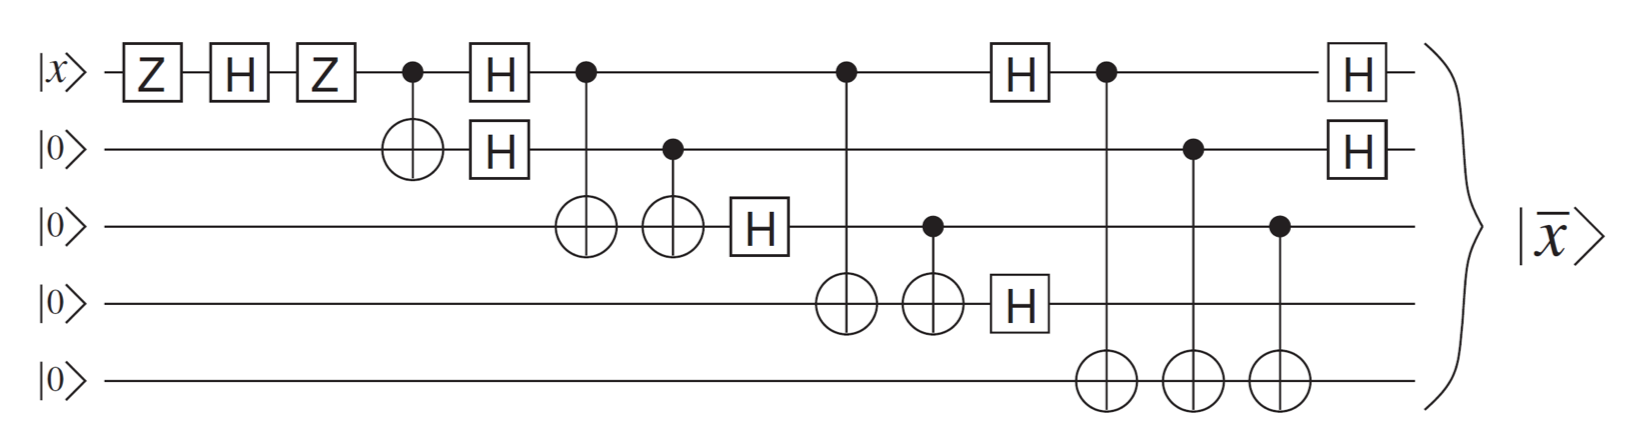

In [ ]:
def perfect_encoding(qc, qx):
    # Encode qubit qx[0] using the five-qubit "perfect" code.
    qc.z(qx[0])
    qc.h(qx[0])
    qc.z(qx[0])
    qc.cx(qx[0], qx[1])
    qc.h(qx[0])
    qc.h(qx[1])
    qc.barrier()
    qc.cx(qx[0], qx[2])
    qc.cx(qx[1], qx[2])
    qc.h(qx[2])
    qc.barrier()
    qc.cx(qx[0], qx[3])
    qc.cx(qx[2], qx[3])
    qc.barrier()
    qc.h(qx[0])
    qc.h(qx[3])
    qc.barrier()
    qc.cx(qx[0], qx[4])
    qc.cx(qx[1], qx[4])
    qc.cx(qx[2], qx[4])
    qc.barrier()
    qc.h(qx[0])
    qc.h(qx[1])
    return

In [ ]:
def perfect_decoding(qc, qx):
    # Decode qubit qx[0] using the five-qubit "perfect" code. (just reverse it)
    qc.h(qx[1])
    qc.h(qx[0])
    qc.barrier()
    qc.cx(qx[2], qx[4])
    qc.cx(qx[1], qx[4])
    qc.cx(qx[0], qx[4])
    qc.barrier()
    qc.h(qx[3])
    qc.h(qx[0])
    qc.barrier()
    qc.cx(qx[2], qx[3])
    qc.cx(qx[0], qx[3])
    qc.barrier()
    qc.h(qx[2])
    qc.cx(qx[1], qx[2])
    qc.cx(qx[0], qx[2])
    qc.barrier()
    qc.h(qx[1])
    qc.h(qx[0])
    qc.cx(qx[0], qx[1])
    qc.z(qx[0])
    qc.h(qx[0])
    qc.z(qx[0])
    return

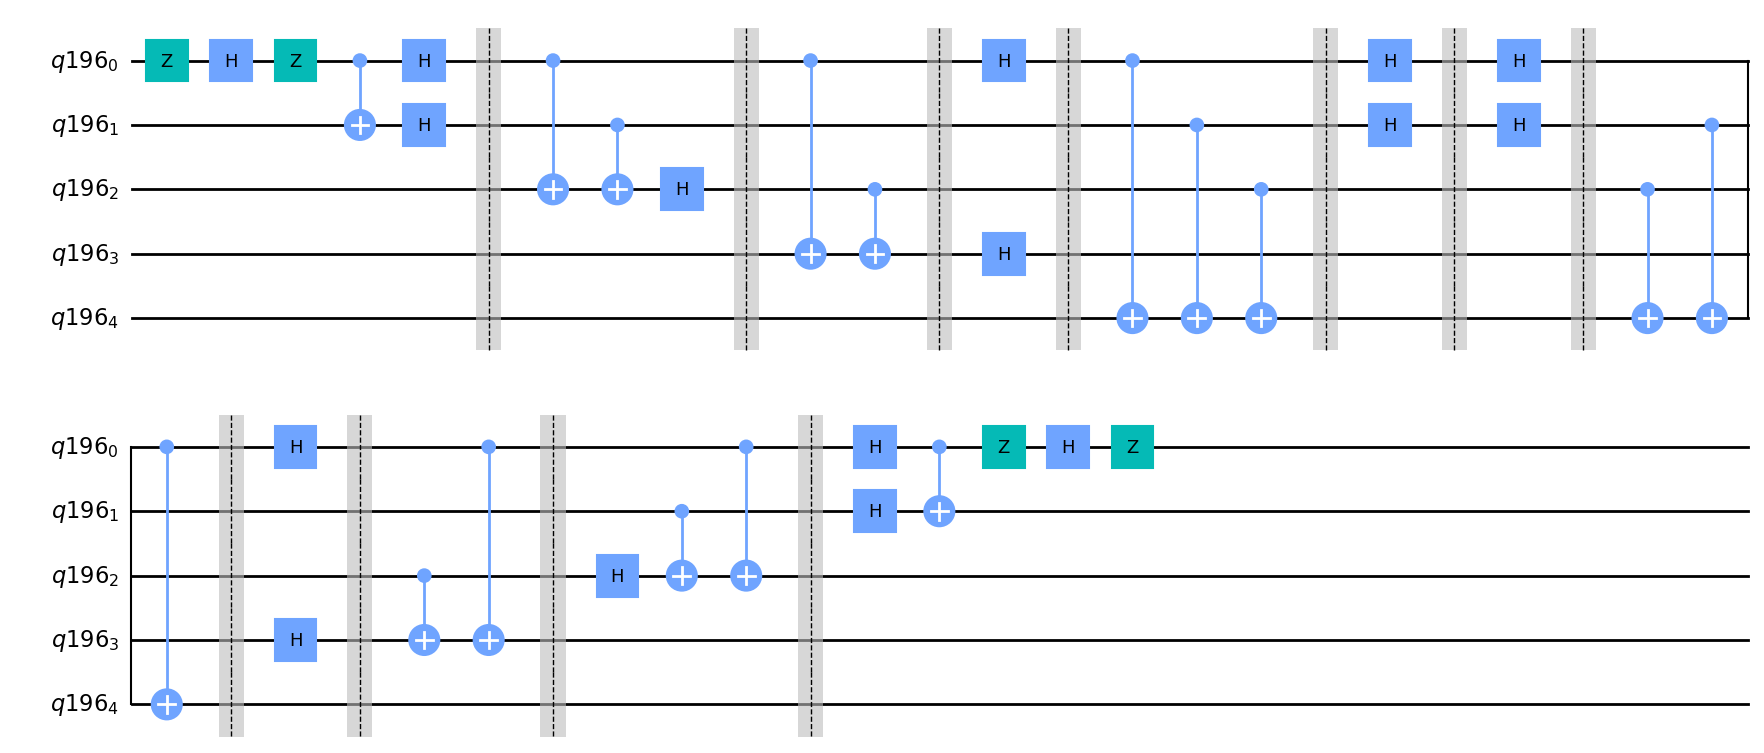

In [ ]:
qx=QuantumRegister(5)
qc=QuantumCircuit(qx)

perfect_encoding(qc,qx)
qc.barrier()
perfect_decoding(qc,qx)
qc.draw('mpl')

## Error Model
**Do not modify**

In [ ]:
def error_model(qc, qx, e=None, k=None):
    # Apply a random single-qubit error to one of the encoding qubits
    # DO NOT MODIFY!

    if (e is None):
        e = np.random.randint(0,5) # 0 = no error, 1 = X error, 2 = Y error, 3 = Z error, 4 = random unitary
    if (k is None):
        k = np.random.randint(0,5) # index of qubit on which error occurs

    if e == 0:
        print("no error")
        pass # no error - do nothing
    elif e == 1:
        print("X error on qubit " + str(k))
        qc.x(qx[k]) # bit-flip error on qubit k
    elif e == 2:
        print("Y error on qubit " + str(k))
        qc.y(qx[k]) # bit-flip & phase error on qubit k
    elif e == 3:
        print("Z error on qubit " + str(k))
        qc.z(qx[k]) # phase error on qubit k
    else:
        print("Random unitary on qubit " + str(k))
        theta = np.arccos(2*rand()-1)
        phi = 2*np.pi*rand()
        lamb = 2*np.pi*rand()
        qc.u(theta, phi, lamb, qx[k])

## Syndrome Measurement

$$\textbf{Stabilizers}$$

$$\begin{align}
\mathbf{M}_{0}=&\mathbf{Z}_{1}\mathbf{X}_{2}\mathbf{X}_{3}\mathbf{Z}_{4} \\
\mathbf{M}_{1}=&\mathbf{Z}_{2}\mathbf{X}_{3}\mathbf{X}_{4}\mathbf{Z}_{0} \\
\mathbf{M}_{2}=&\mathbf{Z}_{3}\mathbf{X}_{4}\mathbf{X}_{0}\mathbf{Z}_{1} \\
\mathbf{M}_{3}=&\mathbf{Z}_{4}\mathbf{X}_{0}\mathbf{X}_{1}\mathbf{Z}_{2} \\
\end{align}$$

In [ ]:
def perfect_syndrome(qc, qx, qs):
    # Apply gates to build the syndrome circuit.
    # Measurements will be in the conditional step, not this one.
    # Put your code here
    qc.h(qs[0])
    qc.h(qs[1])
    qc.h(qs[2])
    qc.h(qs[3])
    qc.barrier()

    # M0 stabilizer
    qc.mcp(np.pi, [qs[0]], [qx[1], qx[4]])
    qc.mcx([qs[0]], [qx[2], qx[3]])
    qc.barrier()

    # M1 stabilizer
    qc.mcp(np.pi, [qs[1]], [qx[0], qx[2]])
    qc.mcx([qs[1]], [qx[3], qx[4]])
    qc.barrier()

    # M2 stabilizer
    qc.mcp(np.pi, [qs[2]], [qx[1], qx[3]])
    qc.mcx([qs[2]], [qx[0], qx[4]])
    qc.barrier()

    # M3 stabilizer
    qc.mcp(np.pi, [qs[3]], [qx[2], qx[4]])
    qc.mcx([qs[3]], [qx[0], qx[1]])
    qc.barrier()

    qc.h(qs[0])
    qc.h(qs[1])
    qc.h(qs[2])
    qc.h(qs[3])
    return

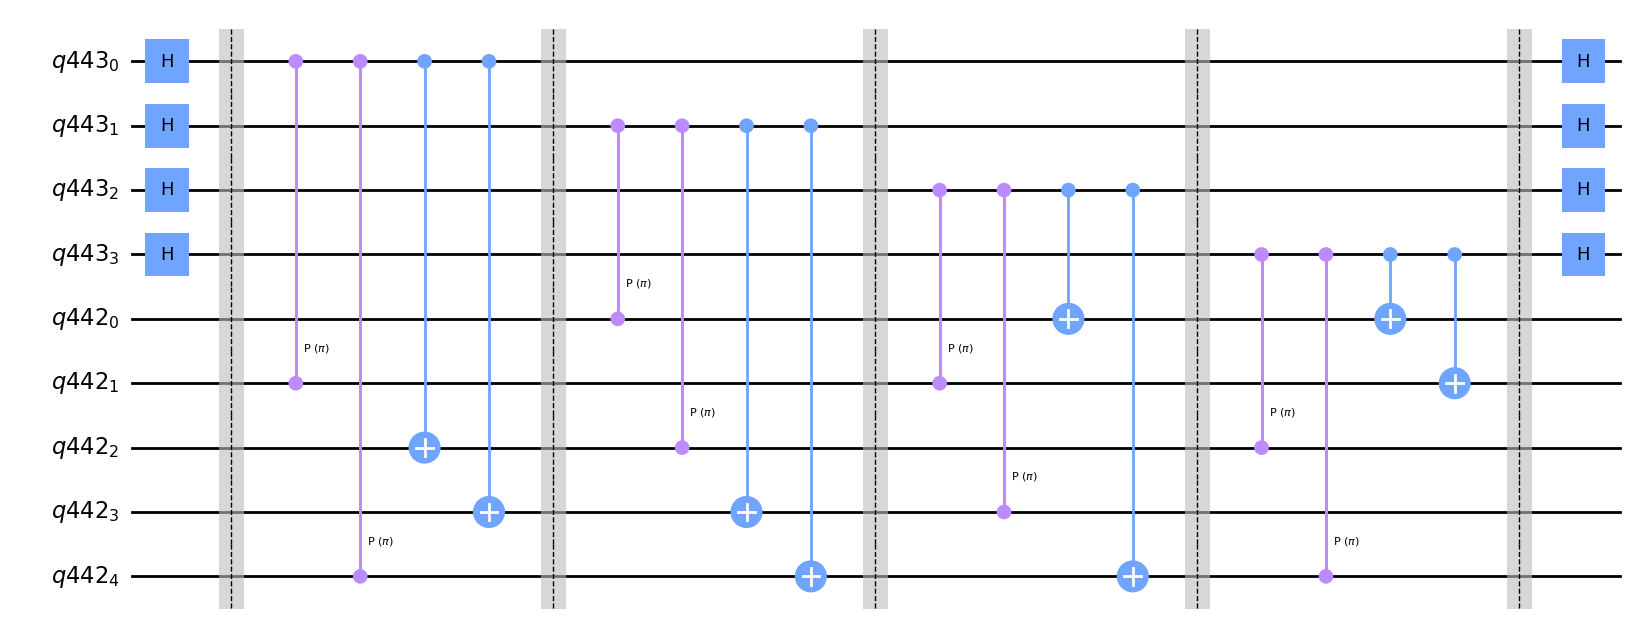

In [ ]:
qx = qiskit.QuantumRegister(5)
qs = qiskit.QuantumRegister(4)
qc = qiskit.QuantumCircuit(qs,qx)

perfect_syndrome(qc,qx,qs)

qc.draw('mpl')

## Error Correction

In [ ]:
def perfect_qec_conditionals(qc, qx, qs, cs):
    # Correct errors using measured syndromes and conditional gates
    qc.measure(qs[0], cs[0])
    qc.measure(qs[1], cs[1])
    qc.measure(qs[2], cs[2])
    qc.measure(qs[3], cs[3])

    # IMPORTANT: to find the control conditions, find how the operators
    # commute with each stabilizer. Each stabilizer they do NOT commute with
    # represents the 4 bit syndrome
    qc.z(qx[2]).c_if(cs, 1)
    qc.x(qx[0]).c_if(cs, 2)
    qc.z(qx[3]).c_if(cs, 3)
    qc.x(qx[3]).c_if(cs, 4)
    qc.x(qx[1]).c_if(cs, 5)
    qc.z(qx[4]).c_if(cs, 6)
    qc.y(qx[3]).c_if(cs, 7)
    qc.z(qx[1]).c_if(cs, 8)
    qc.x(qx[4]).c_if(cs, 9)
    qc.x(qx[2]).c_if(cs, 10)
    qc.y(qx[2]).c_if(cs, 11)
    qc.z(qx[0]).c_if(cs, 12)
    qc.y(qx[1]).c_if(cs, 13)
    qc.y(qx[0]).c_if(cs, 14)
    qc.y(qx[4]).c_if(cs, 15)
    return


In [ ]:
def perfect_qec_controls(qc, qx, qs):
    # Correct errors using controlled gates instead of conditional gates
    controllist = [qs[0], qs[1], qs[2], qs[3]]

    # 1
    qc.x(qs[1])
    qc.x(qs[2])
    qc.x(qs[3])
    qc.mcp(np.pi, controllist, qx[2])
    qc.x(qs[1])
    qc.x(qs[2])
    qc.x(qs[3])

    # 2
    qc.x(qs[0])
    qc.x(qs[2])
    qc.x(qs[3])
    qc.mcx(controllist, qx[0])
    qc.x(qs[0])
    qc.x(qs[2])
    qc.x(qs[3])

    # 3
    qc.x(qs[2])
    qc.x(qs[3])
    qc.mcp(np.pi, controllist, qx[3])
    qc.x(qs[2])
    qc.x(qs[3])

    # 4
    qc.x(qs[0])
    qc.x(qs[1])
    qc.x(qs[3])
    qc.mcx(controllist, qx[3])
    qc.x(qs[0])
    qc.x(qs[1])
    qc.x(qs[3])

    # 5
    qc.x(qs[1])
    qc.x(qs[3])
    qc.mcx(controllist, qx[1])
    qc.x(qs[1])
    qc.x(qs[3])

    # 6
    qc.x(qs[0])
    qc.x(qs[3])
    qc.mcp(np.pi, controllist, qx[4])
    qc.x(qs[0])
    qc.x(qs[3])

    # 7
    qc.x(qs[3])
    qc.mcry(np.pi, controllist, qx[3])
    qc.x(qs[3])

    # 8
    qc.x(qs[0])
    qc.x(qs[1])
    qc.x(qs[2])
    qc.mcp(np.pi, controllist, qx[1])
    qc.x(qs[0])
    qc.x(qs[1])
    qc.x(qs[2])

    # 9
    qc.x(qs[1])
    qc.x(qs[2])
    qc.mcx(controllist, qx[4])
    qc.x(qs[1])
    qc.x(qs[2])

    # 10
    qc.x(qs[0])
    qc.x(qs[2])
    qc.mcx(controllist, qx[2])
    qc.x(qs[0])
    qc.x(qs[2])

    # 11
    qc.x(qs[2])
    qc.mcry(np.pi, controllist, qx[2])
    qc.x(qs[2])

    # 12
    qc.x(qs[0])
    qc.x(qs[1])
    qc.mcp(np.pi, controllist, qx[0])
    qc.x(qs[0])
    qc.x(qs[1])

    # 13
    qc.x(qs[1])
    qc.mcry(np.pi, controllist, qx[1])
    qc.x(qs[1])

    # 14
    qc.x(qs[0])
    qc.mcry(np.pi, controllist, qx[0])
    qc.x(qs[0])

    # 15
    qc.mcry(np.pi, controllist, qx[4])



    return

## Main Code Block
This executes the entire protocol.

In [ ]:
# This double for loop runs everything for convenience. As you will see in the
# results, there is no error for every case!
for Q in range(5):
  for R in range(5):
    n = 5 # number of physical qubits
    k = 1 # number of logical qubits

    # prepare the quantum circuit
    qx = qiskit.QuantumRegister(n)
    qs = qiskit.QuantumRegister(n-k)
    cx = qiskit.ClassicalRegister(n)
    cs = qiskit.ClassicalRegister(n-k)
    qc = qiskit.QuantumCircuit(qs, qx, cx, cs)

    # prepare a random single-qubit state in qx[0]
    theta = np.arccos(2*rand()-1)
    phi = 2*np.pi*rand()
    lamb = 0
    qc.u(theta, phi, lamb, qx[0])


    # encode the qubit using the 5-qubit perfect code
    perfect_encoding(qc, qx)
    qc.barrier()

    # apply a random error to one of the encoding qubits
    error_model(qc, qx, Q, R) # Q, R
    qc.barrier()

    # apply gates to perform a syndrome measurement
    perfect_syndrome(qc, qx, qs)
    qc.barrier()

    # detect and correct error using the syndromes
    perfect_qec_conditionals(qc, qx, qs, cs)
    #perfect_qec_controls(qc, qx, qs)
    qc.barrier()

    # decode the corrected, encoded qubit
    perfect_decoding(qc, qx)
    qc.barrier()

    # prepare qubit qx[0] for measurement
    qc.u(theta, np.pi-lamb, np.pi-phi, qx[0])
    qc.barrier()

    # measure the qx register
    for i in range(len(qx)):
      qc.measure(qx[i], cx[i])

    # measure the qs register
    for j in range(len(qs)):
      qc.measure(qs[j], cs[j])

    # execute the quantum circuit
    backend =  qiskit.Aer.get_backend('qasm_simulator')
    job = qiskit.execute(qc, backend, shots=1024)
    data = job.result().get_counts(qc)
    print(data)
    print("")

no error
{'0000 00000': 1024}

no error
{'0000 00000': 1024}

no error
{'0000 00000': 1024}

no error
{'0000 00000': 1024}

no error
{'0000 00000': 1024}

X error on qubit 0
{'0010 00000': 1024}

X error on qubit 1
{'0101 00000': 1024}

X error on qubit 2
{'1010 00000': 1024}

X error on qubit 3
{'0100 00000': 1024}

X error on qubit 4
{'1001 00000': 1024}

Y error on qubit 0
{'1110 00000': 1024}

Y error on qubit 1
{'1101 00000': 1024}

Y error on qubit 2
{'1011 00000': 1024}

Y error on qubit 3
{'0111 00000': 1024}

Y error on qubit 4
{'1111 00000': 1024}

Z error on qubit 0
{'1100 00000': 1024}

Z error on qubit 1
{'1000 00000': 1024}

Z error on qubit 2
{'0001 00000': 1024}

Z error on qubit 3
{'0011 00000': 1024}

Z error on qubit 4
{'0110 00000': 1024}

Random unitary on qubit 0
{'1110 00000': 36, '1100 00000': 129, '0000 00000': 521, '0010 00000': 338}

Random unitary on qubit 1
{'1000 00000': 1, '1101 00000': 161, '0101 00000': 576, '0000 00000': 286}

Random unitary on qubit 2

**<font color='red'>After decoding, you can see that both the quantum and classical controls/conditionals return all 0s in the qx space, indicating that the error did not affect the final measurement. In other words, it was corrected.</font>**

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


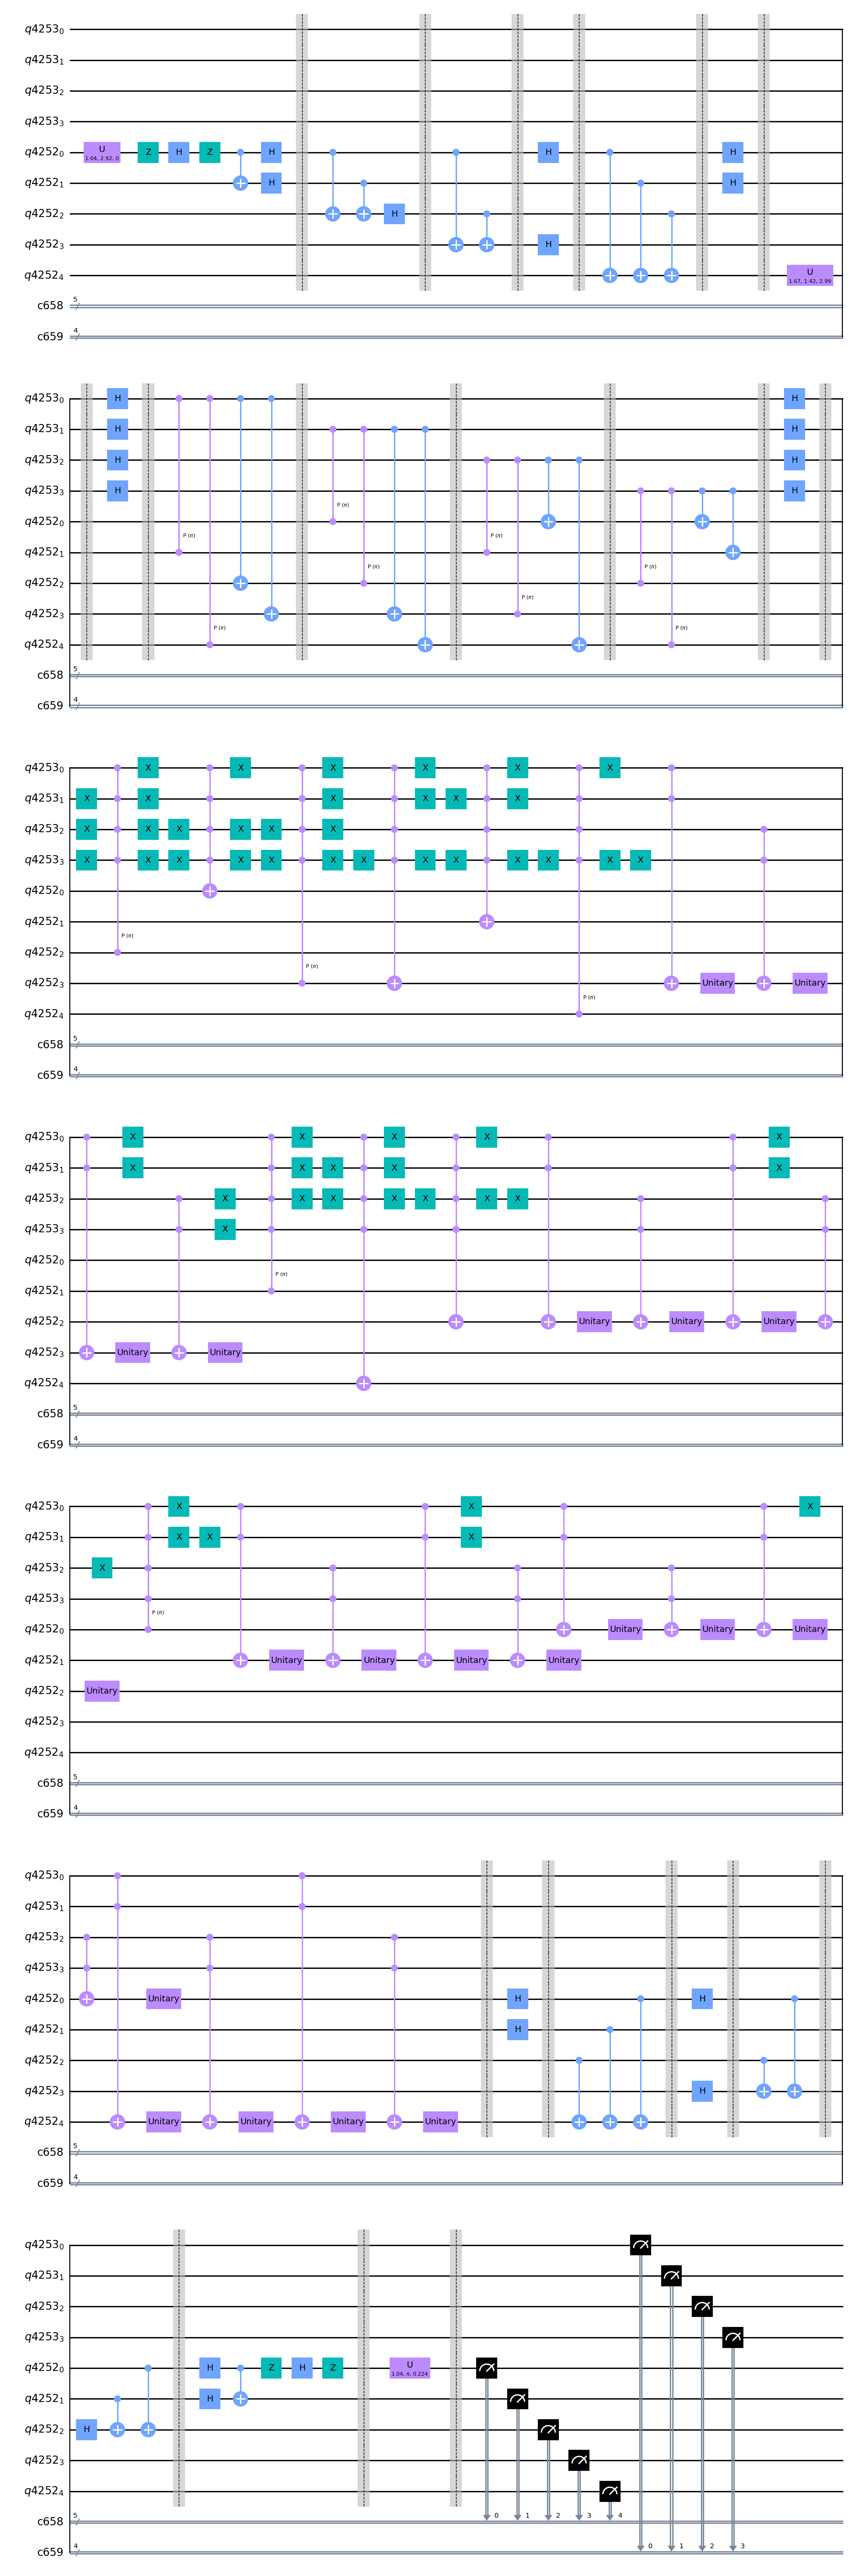

In [ ]:
qc.draw('mpl')